# IMPORTACIÓN LIBRERIAS


In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# CARGA DE ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

Se importan todos los archivos csv que se han creado para juntar la info y trabajar con ellos para que salga el documento final para el modelo.

In [4]:
abonados = load_dataset('../data/abonados_final_pre_modelo.csv')
servicios_extra = load_dataset('../data/servicios_final.csv')
economia = load_dataset('../data/economia_final_pre_modelo.csv')
accesos = load_dataset('../data/resumen_accesos_pre_modelo.csv')

# PRIMERA PARTE: ABONADOS + SERVICIOS EXTRA

In [15]:
def merge_y_limpiar_usuarios_servicios(df_usuarios_final, df_servicios_final):
    """
    Realiza el merge entre usuarios y servicios, y prepara la limpieza de NaNs y tipos.
    
    Parámetros:
    - df_usuarios_final: DataFrame con info de usuarios (altas, bajas, etc)
    - df_servicios_final: DataFrame con info de servicios por usuario
    
    Retorna:
    - df_merge: DataFrame combinado y limpio listo para análisis/modelado
    """
    # Merge con left join para mantener todos usuarios
    df_merge = pd.merge(df_usuarios_final, df_servicios_final, on='IdPersona', how='left')

    # Rellenar UsoServiciosExtra con False en NaNs
    df_merge['UsoServiciosExtra'] = df_merge['UsoServiciosExtra'].fillna(False)

    # Seleccionar columnas que comienzan con 'Concepto_' y rellenar NaN con 0, luego a bool
    concepto_cols = [col for col in df_merge.columns if col.startswith('Concepto_')]
    if concepto_cols:
        df_merge[concepto_cols] = df_merge[concepto_cols].fillna(0).astype(bool)

    # Columnas numéricas que deben rellenarse con 0 para evitar NaNs
    columnas_a_rellenar = [
        'Importe_2024_servicios', 'Cantidad_2024_servicios',
        'Importe_2025_servicios', 'Cantidad_2025_servicios',
        'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios',
        'TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_FISIOTERÀPIA',
        'TipoServicio_NUTRICIÓ', 'Total_conceptos_unicos',
        'Total_tipos_servicios_unicos'
    ]

    for col in columnas_a_rellenar:
        if col in df_merge.columns:
            df_merge[col] = df_merge[col].fillna(0)

    return df_merge


In [17]:
df_abonados_servicios = merge_y_limpiar_usuarios_servicios(abonados, servicios_extra)
df_abonados_servicios

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_2024_servicios,Cantidad_2024_servicios,Importe_2025_servicios,Cantidad_2025_servicios,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT,Concepto_ENTRENADOR PERSONAL 1 SESSIO,Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT,Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS),Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT,Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT,Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT,Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 30' ABONAT,Concepto_FISIO ABONAMENT 5 SESSIONS 60',Concepto_FISIO PACK BENVINGUDA,Concepto_FISIOTERÀPIA 60' ABONAT,Concepto_FISIOTERÀPIA 30' ABONAT,Concepto_NUTRI ANTROPOMETRIA,Concepto_NUTRI ANTROPOMETRIA ABONAT,Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT,Concepto_NUTRI VISITA DE SEGUIMENT ABONAT,Concepto_PACK 3 SEGUIMENTS ABONAT,Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,Total_conceptos_unicos,Total_tipos_servicios_unicos,UsoServiciosExtra
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
7826,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
7827,117277,7,2025-08-06,AM00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,False
7828,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,-1.0,-1.0,

In [18]:
def eda_basica(df: pd.DataFrame, nombre_df: str = "DataFrame") -> None:
    """
    Realiza un análisis exploratorio básico sobre un DataFrame:
    - Identifica variables numéricas y categóricas
    - Detecta valores nulos y muestra una visualización si los hay
    - Revisa duplicados (filas y columnas)

    Parámetros:
        df (pd.DataFrame): El DataFrame a analizar
        nombre_df (str): Nombre para mostrar del DataFrame (opcional)
    """
    print(f"\n📋 Análisis EDA básico de: {nombre_df}")

    # 1. Tipos de variables
    print("\n📌 Tipos de Variables:")
    num_vbles = df.select_dtypes(include='number').columns.tolist()
    cat_vbles = df.select_dtypes(exclude='number').columns.tolist()
    print(f"🔢 Variables Numéricas: {num_vbles}")
    print(f"🔠 Variables Categóricas: {cat_vbles}")

    # 2. Valores nulos
    print("\n🕳️ Variables con valores nulos:")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    missing_percentage = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Total Missing': missing,
        'Percentage Missing': missing_percentage
    })

    if not missing.empty:
        display(missing_df)
        plt.figure(figsize=(10, 6))
        missing.plot(kind='barh', color='salmon')
        plt.title("Variables con Valores Nulos")
        plt.xlabel("Cantidad de valores nulos")
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("✅ No hay valores nulos en el dataset.")

    # 3. Filas duplicadas
    print("\n📎 Filas duplicadas:")
    duplicadas = df.duplicated().sum()
    if duplicadas > 0:
        print(f"🔴 Hay {duplicadas} filas duplicadas.")
        display(df[df.duplicated()])
    else:
        print("✅ No hay filas duplicadas.")

    # 4. Columnas duplicadas
    print("\n📎 Columnas duplicadas:")
    columnas_duplicadas = df.T.duplicated().sum()
    if columnas_duplicadas > 0:
        print(f"🔴 Hay {columnas_duplicadas} columnas duplicadas.")
    else:
        print("✅ No hay columnas duplicadas.")


📋 Análisis EDA básico de: Clientes con Servicios Extra

📌 Tipos de Variables:
🔢 Variables Numéricas: ['IdPersona', 'Edad', 'NumAltasAntesDelPeriodo', 'MesesDesdeUltimaAltaPrevia', 'MesesDuracionAbonoActual', 'NumAltasEnPeriodo', 'MesesDesdePrimeraAltaEnPeriodo', 'VidaGymMeses', 'NumBajasEnPeriodo', 'MesesDesdeUltimaBaja', 'Importe_2024_servicios', 'Cantidad_2024_servicios', 'Importe_2025_servicios', 'Cantidad_2025_servicios', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_FISIOTERÀPIA', 'TipoServicio_NUTRICIÓ', 'Total_conceptos_unicos', 'Total_tipos_servicios_unicos']
🔠 Variables Categóricas: ['FechaInscripcion', 'TipoAbonoActual', 'Sexo_Mujer', 'FAntiguedad', 'TuvoAltasPrevias', 'EsChurn', 'FechaFin', 'FechaUltimaBajaEnPeriodo', 'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT', 'Concepto_ENTRENADOR PERSONAL 1 SESSIO', 'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT', 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)

,Total Missing,Percentage Missing
FechaUltimaBajaEnPeriodo,4971,63.48659


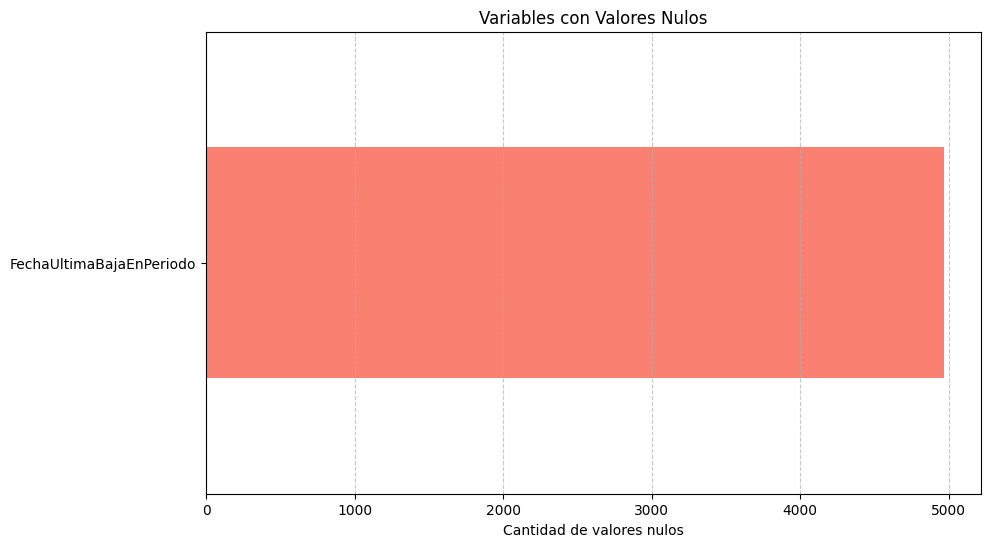


📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
🔴 Hay 2 columnas duplicadas.


In [19]:
eda_basica(df_abonados_servicios, nombre_df="Clientes con Servicios Extra")

Volvemos a confirmar que no hayan columnas duplicadas despues de comprobar a vista las columnas que tiene

In [21]:
# Obtener las columnas duplicadas
duplicadas = df_abonados_servicios.columns[df_abonados_servicios.columns.duplicated()]

print("Columnas duplicadas:", duplicadas.tolist())

Columnas duplicadas: []


## FEATURE POST MERGE

In [22]:
def crear_features_servicios(df, columnas_a_eliminar=None):
    """
    Crea features resumen sobre uso y ratios de servicios y elimina columnas indicadas.
    
    Parámetros:
    - df: DataFrame con datos mergeados de usuarios y servicios
    - columnas_a_eliminar: lista de columnas a eliminar después de crear los features (opcional)
    
    Retorna:
    - df con nuevas columnas y columnas eliminadas según parámetro
    """

    # Evitar división por cero sumando 1 en denominadores
    df["ratio_importe_2025_2024"] = df["Importe_2025_servicios"] / (df["Importe_2024_servicios"] + 1)
    df["ratio_cantidad_2025_2024"] = df["Cantidad_2025_servicios"] / (df["Cantidad_2024_servicios"] + 1)

    # Variables booleanas de uso de servicios por patrones en nombres de columnas
    df["Uso_entrenamientos_personales"] = (
        df.filter(regex="ENTRENADOR PERSONAL|ENTRENAMENTS PERSONALS").sum(axis=1) > 0
    )

    df["Uso_fisioterapia"] = (
        df.filter(regex="FISIO|FISIOTERÀPIA").sum(axis=1) > 0
    )

    df["Uso_nutricion"] = (
        df.filter(regex="NUTRI").sum(axis=1) > 0
    )

    # Diversidad: cuántos tipos de servicio usa (de esas 3 categorías)
    df["Diversidad_servicios_extra"] = (
        df[["Uso_entrenamientos_personales", "Uso_fisioterapia", "Uso_nutricion"]].sum(axis=1)
    )

    # Eliminar columnas indicadas si se pasan
    if columnas_a_eliminar:
        cols_existentes = [col for col in columnas_a_eliminar if col in df.columns]
        df = df.drop(columns=cols_existentes)

    return df



In [23]:
cols_a_borrar = [
    'Importe_2024_servicios', 'Cantidad_2024_servicios', 'Importe_2025_servicios', 'Cantidad_2025_servicios',
    'Concepto_ENTRENADOR PERSONAL 1 /2 SESSIO ABONAT', 'Concepto_ENTRENADOR PERSONAL 1 SESSIO',
    'Concepto_ENTRENADOR PERSONAL 1 SESSIÓ ABONAT', 'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS)',
    'Concepto_ENTRENADOR PERSONAL 10 (30 MINUTS) ABONAT', 'Concepto_ENTRENADOR PERSONAL 10 SESSIONS ABONAT',
    'Concepto_ENTRENADOR PERSONAL 5 (30 MINUTS) ABONAT', 'Concepto_ENTRENADOR PERSONAL 5 SESSIONS ABONAT',
    "Concepto_FISIO ABONAMENT 10 SESSIONS 60' ABONAT", "Concepto_FISIO ABONAMENT 5 SESSIONS  30' ABONAT",
    "Concepto_FISIO ABONAMENT 5 SESSIONS  60'  ", 'Concepto_FISIO PACK BENVINGUDA',
    "Concepto_FISIOTERÀPIA  60' ABONAT", "Concepto_FISIOTERÀPIA 30' ABONAT", 'Concepto_NUTRI ANTROPOMETRIA',
    'Concepto_NUTRI ANTROPOMETRIA ABONAT', 'Concepto_NUTRI PACK 3 SEGUIMENTS ABONAT',
    'Concepto_NUTRI VISITA DE SEGUIMENT ABONAT', 'Concepto_PACK 3 SEGUIMENTS ABONAT',
    'Concepto_PACK NUTRICIÓ (2 VISITES) ABONAT', 'Total_tipos_servicios_unicos', 'Total_conceptos_unicos'
]

df_final_features = crear_features_servicios(df_abonados_servicios, columnas_a_eliminar=cols_a_borrar)

In [24]:
df_final_features

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
7826,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
7827,117277,7,2025-08-06,AM00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0
7828,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.833333,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0


In [25]:
# Resumen numérico básico
display(df_final_features.describe(include='number').T)

# Resumen categórico básico
display(df_final_features.describe(include=['object','category','bool']).T)

,count,mean,std,min,25%,50%,75%,max
IdPersona,7830.0,99888.940868,25395.746558,334.0,98097.250000,108802.500000,114462.750000,117538.0
Edad,7830.0,41.744572,20.070896,0.0,26.000000,41.000000,55.000000,225.0
NumAltasAntesDelPeriodo,7830.0,-0.010983,0.861686,-1.0,-1.000000,0.000000,1.000000,3.0
MesesDesdeUltimaAltaPrevia,7830.0,13.490166,37.529345,-1.0,-1.000000,-1.000000,9.000000,827.0
MesesDuracionAbonoActual,7830.0,18.494508,39.558138,-1.0,-1.000000,3.000000,20.000000,839.0
NumAltasEnPeriodo,7830.0,-0.150575,0.746386,-1.0,-1.000000,0.000000,0.000000,1.0
MesesDesdePrimeraAltaEnPeriodo,7830.0,0.300894,3.050038,-1.0,-1.000000,-1.000000,-1.000000,12.0
VidaGymMeses,7830.0,23.920796,42.052886,0.0,3.066667,9.966667,26.041667,839.5
NumBajasEnPeriodo,7830.0,0.394636,0.549338,0.0,0.000000,0.000000,1.000000,3.0
MesesDesdeUltimaBaja,7830.0,2.014304,3.566216,0.0,0.000000,0.000000,3.000000,12.0


,count,unique,top,freq
FechaInscripcion,7830,1262,2025-09-01,326
TipoAbonoActual,7830,48,AA00,2590
Sexo_Mujer,7830,2,True,4220
FAntiguedad,7830,2021,2025-09-01,87
TuvoAltasPrevias,7830,2,False,5145
EsChurn,7830,2,False,4971
FechaFin,7830,52,2025-09-01,5320
FechaUltimaBajaEnPeriodo,2859,41,2025-09-01,394
UsoServiciosExtra,7830,2,False,7794
Uso_entrenamientos_personales,7830,2,False,7813


Hay un pequeño error encontrado al ver el numero máximo de edad. Es impossible que haya una persona con 225 años. Por lo tanto hay algun error en alguna fecha asi que se decide eliminarlos.

In [27]:
df = df_final_features[df_final_features['Edad'] != 225]

In [28]:
# Resumen numérico básico
display(df.describe(include='number').T)

,count,mean,std,min,25%,50%,75%,max
IdPersona,7821.0,99950.052807,25346.333444,334.0,98144.000000,108814.000000,114467.000000,117538.0
Edad,7821.0,41.533691,19.094764,0.0,25.000000,41.000000,55.000000,97.0
NumAltasAntesDelPeriodo,7821.0,-0.012019,0.861575,-1.0,-1.000000,0.000000,1.000000,3.0
MesesDesdeUltimaAltaPrevia,7821.0,13.501982,37.549230,-1.0,-1.000000,-1.000000,9.000000,827.0
MesesDuracionAbonoActual,7821.0,18.498530,39.580601,-1.0,-1.000000,3.000000,20.000000,839.0
NumAltasEnPeriodo,7821.0,-0.150748,0.746798,-1.0,-1.000000,0.000000,0.000000,1.0
MesesDesdePrimeraAltaEnPeriodo,7821.0,0.302391,3.051473,-1.0,-1.000000,-1.000000,-1.000000,12.0
VidaGymMeses,7821.0,23.930226,42.076056,0.0,3.066667,9.966667,26.066667,839.5
NumBajasEnPeriodo,7821.0,0.395090,0.549491,0.0,0.000000,0.000000,1.000000,3.0
MesesDesdeUltimaBaja,7821.0,2.016622,3.567612,0.0,0.000000,0.000000,3.000000,12.0


| **Variable**                      | **Descripción**                                                  | **Utilidad para el modelo (predictiva y explicativa)**                      |
| --------------------------------- | ---------------------------------------------------------------- | --------------------------------------------------------------------------- |
| `Importe_2024_servicios`          | Total € gastado en servicios extra en 2024                       | Indica compromiso pasado con servicios; puede correlacionar con retención   |
| `Cantidad_2024_servicios`         | Número de servicios extra comprados en 2024                      | Mide frecuencia de uso en 2024                                              |
| `Importe_2025_servicios`          | Total € gastado en 2025                                          | Mide uso reciente; muy relevante si el modelo se entrena con datos actuales |
| `Cantidad_2025_servicios`         | Número de servicios extra usados en 2025                         | Lo mismo que arriba, pero en frecuencia                                     |
| `Importe_total_pagado_servicios`  | Suma total de gasto en servicios 2024 + 2025                     | Indica valor económico del cliente en extras                                |
| `Cantidad_total_pagado_servicios` | Suma total de servicios utilizados en 2024 + 2025                | Relevante para medir compromiso en el tiempo                                |
| `ratio_importe_2025_2024`         | Cambio proporcional del gasto 2024 → 2025                        | Detecta crecimiento o disminución de uso (engagement)                       |
| `ratio_cantidad_2025_2024`        | Cambio proporcional en frecuencia 2024 → 2025                    | Similar al anterior, pero en número de usos                                 |
| `Uso_entrenamientos_personales`   | Flag si ha usado entrenamientos personales                       | Identifica interés en entrenamientos → puede estar más fidelizado           |
| `Uso_fisioterapia`                | Flag si ha usado servicios de fisio                              | Idem, puede indicar mayor necesidad del centro y compromiso                 |
| `Uso_nutricion`                   | Flag si ha usado nutrición                                       | Puede correlacionar con perfil más comprometido y completo                  |
| `Diversidad_servicios_extra`      | Nº de categorías de servicios distintos que ha usado (0–3)       | Indica cuán completo es su uso del centro → mayor engagement posible        |
| `Total_conceptos_unicos`          | Nº de conceptos únicos distintos que ha comprado                 | Captura variedad específica de productos comprados                          |
| `UsoServiciosExtra`               | Flag general si ha usado **algún** servicio extra                | Indicador binario útil como split base para análisis                        |


✅ ¿Qué aportan estas variables?

- Variables cuantitativas (importe, cantidad, ratios) aportan:

 · Señal de intensidad y evolución del uso.
 · Posible correlación con abandono (ej. bajada de uso → abandono).

- Variables categóricas/bool (Uso_*) aportan:

 · Interpretabilidad y segmentación.
 · Son especialmente útiles en modelos de árboles y para business insights.

- Variables de diversidad:

 · Aportan una medida de amplitud del engagement (no solo cuánto, sino cuán variado).

# SEGUNDA PARTE UNIÓN: ABONADOS Y SERVICIOS + ECONOMIA

In [29]:
def unir_con_features_economia(df: pd.DataFrame, df_agg: pd.DataFrame) -> pd.DataFrame:
    """
    Une el DataFrame original con el DataFrame de features económicos agregados
    por la columna 'IdPersona'. Convierte 'IdPersona' a string en ambos DataFrames
    antes de hacer la unión.
    
    Retorna una copia del DataFrame resultante para evitar efectos colaterales.
    """

    df = df.copy()
    df_agg = df_agg.copy()

    # Asegurar que 'IdPersona' sea string en ambos DataFrames
    df['IdPersona'] = df['IdPersona'].astype(str)
    df_agg['IdPersona'] = df_agg['IdPersona'].astype(str)

    # Unir los DataFrames por 'IdPersona'
    union = pd.merge(df, df_agg, on='IdPersona', how='left')

    return union.copy()


In [31]:
union_economia = unir_con_features_economia(df, economia)
union_economia

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra,NumPagosEconomia,MediaIntervaloMeses,StdIntervaloMeses,UltimoPagoMesEconomia,PrimerPagoMesEconomia,MesesConPagoEconomia,PorcentajeMesesPagados,TotalPagadoEconomia,media_pagoEconomia,StdPagoEconomia,CoefVarPagoEconomia,PctPagoMetalico,PctPagoRecibo,PctPagoTarjeta,PctPagoTransferencia,NumAbonosDistintos,AbonoMasRecuente,TienePagos
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,12.0,1.015152,0.031140,9.0,10.0,12.0,0.923077,602.80,50.233333,19.289132,0.383991,0.0,1.0,0.0,0.0,3.0,AA00 - ADULTS ( 26 A 64 ANYS ),True
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,7.0,1.022222,0.017213,9.0,3.0,7.0,0.538462,318.25,45.464286,24.739067,0.544143,0.0,1.0,0.0,0.0,2.0,AA00 - ADULTS ( 26 A 64 ANYS ),True
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,4.0,3.044444,0.038490,9.0,12.0,4.0,0.307692,523.27,130.817500,2.565000,0.019607,0.0,1.0,0.0,0.0,1.0,AC03 - COMERCIANTS - TRIMESTRAL,True
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7816,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7817,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7818,117277,7,2025-08-06,AM00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7819,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.833333,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## FEATURE POST MERGE

In [35]:
def preparar_df_union_economia(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara el DataFrame unido con features económicos, rellenando valores nulos en columnas
    categóricas y numéricas según reglas definidas.
    
    Parámetros:
        df (pd.DataFrame): DataFrame unido que contiene las columnas a preparar.
        
    Retorna:
        pd.DataFrame: DataFrame limpio y preparado.
    """
    df = df.copy()
    
    # Rellenar columna booleana 'TienePagos' con False donde haya NaN
    if 'TienePagos' in df.columns:
        df['TienePagos'] = df['TienePagos'].fillna(False)
    
    # Columnas categóricas a rellenar con 'Indefinido'
    categorical_cols = ['AbonoMasRecuente']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Indefinido')
    
    # Columnas numéricas a rellenar con 0
    cols_a_0 = [
        'NumPagosEconomia', 'MediaIntervaloMeses', 'StdIntervaloMeses',
       'UltimoPagoMesEconomia', 'PrimerPagoMesEconomia',
       'MesesConPagoEconomia', 'PorcentajeMesesPagados', 'TotalPagadoEconomia',
       'media_pagoEconomia', 'StdPagoEconomia', 'CoefVarPagoEconomia',
       'PctPagoMetalico', 'PctPagoRecibo', 'PctPagoTarjeta',
       'PctPagoTransferencia', 'NumAbonosDistintos',
    ]
    for col in cols_a_0:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    return df


In [36]:
union_economia_preparado = preparar_df_union_economia(union_economia)
union_economia_preparado

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra,NumPagosEconomia,MediaIntervaloMeses,StdIntervaloMeses,UltimoPagoMesEconomia,PrimerPagoMesEconomia,MesesConPagoEconomia,PorcentajeMesesPagados,TotalPagadoEconomia,media_pagoEconomia,StdPagoEconomia,CoefVarPagoEconomia,PctPagoMetalico,PctPagoRecibo,PctPagoTarjeta,PctPagoTransferencia,NumAbonosDistintos,AbonoMasRecuente,TienePagos
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,12.0,1.015152,0.031140,9.0,10.0,12.0,0.923077,602.80,50.233333,19.289132,0.383991,0.0,1.0,0.0,0.0,3.0,AA00 - ADULTS ( 26 A 64 ANYS ),True
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,7.0,1.022222,0.017213,9.0,3.0,7.0,0.538462,318.25,45.464286,24.739067,0.544143,0.0,1.0,0.0,0.0,2.0,AA00 - ADULTS ( 26 A 64 ANYS ),True
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,4.0,3.044444,0.038490,9.0,12.0,4.0,0.307692,523.27,130.817500,2.565000,0.019607,0.0,1.0,0.0,0.0,1.0,AC03 - COMERCIANTS - TRIMESTRAL,True
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7816,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False
7817,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False
7818,117277,7,2025-08-06,AM00,False,2025-08-06,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.866667,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False
7819,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,-1.0,-1.0,True,2025-09-01,0.833333,1.0,2025-09-01,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False



📌 Variables with missing values:


,Total Missing,Percentage Missing
FechaUltimaBajaEnPeriodo,4962,63.444572


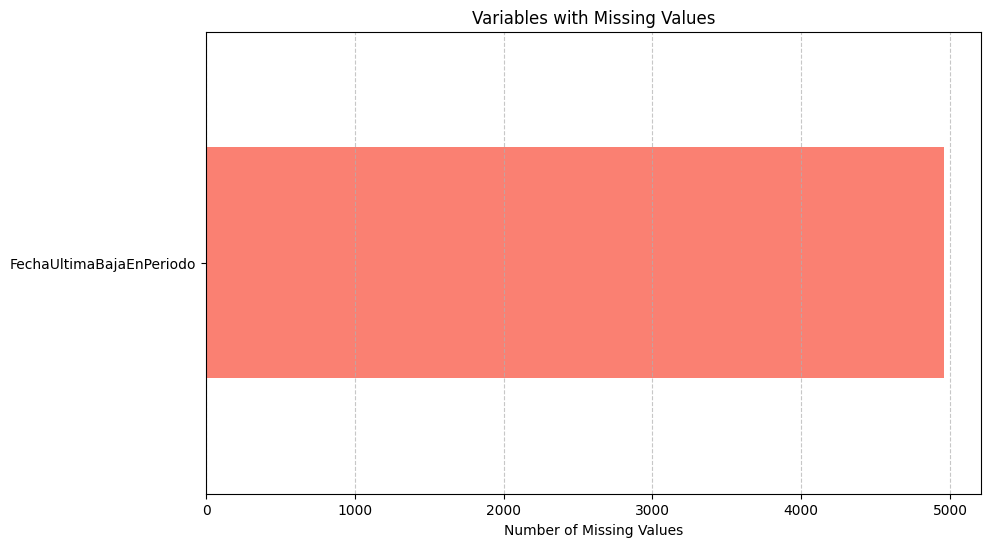

In [37]:
# 4. Variables with missing values
    # Detect columns with missing values and show the percentage
print("\n📌 Variables with missing values:")

# Count missing values by column
missing = union_economia_preparado.isnull().sum()

# Filter only columns with missing values
missing = missing[missing > 0].sort_values(ascending=False)

# Calculate missing percentage
missing_percentage = (missing / len(union_economia_preparado)) * 100

# Create a DataFrame to show the count and percentage of missing values
missing_df = pd.DataFrame({'Total Missing': missing, 'Percentage Missing': missing_percentage})

# If missing values exist, display a bar chart of missing values distribution
if not missing.empty:
    display(missing_df)
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')  # Horizontal bar chart
    plt.title("Variables with Missing Values")
    plt.xlabel("Number of Missing Values")
    plt.gca().invert_yaxis()  # Invert y-axis to show variables with most missing values first
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Add grid to the chart
    plt.show()
else:
    print("✅ No missing values in the dataset.")

| **Variable**               | **Descripción**                                                  | **Utilidad para el modelo (predictiva y explicativa)**                               |
| -------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| `num_pagos_economia`       | Número total de pagos realizados por la persona                  | Indica nivel de actividad económica y compromiso de pago                             |
| `media_intervalo_meses`    | Promedio de meses entre pagos                                    | Refleja regularidad y frecuencia promedio de pagos                                   |
| `std_intervalo_meses`      | Desviación estándar del intervalo entre pagos                    | Muestra variabilidad en la periodicidad de pagos                                     |
| `ultimo_pago_mes_economia` | Mes del último pago registrado                                   | Indica actividad económica reciente, posible señal de continuidad o abandono         |
| `primer_pago_mes_economia` | Mes del primer pago registrado                                   | Marca inicio de relación económica o historial de pagos                              |
| `meses_con_pago_economia`  | Número de meses con al menos un pago                             | Mide constancia y periodicidad en el pago durante el período considerado             |
| `porcentaje_meses_pagados` | Proporción de meses con pago respecto a 13 meses (periodo total) | Refleja nivel de cumplimiento o estabilidad del pago en el tiempo                    |
| `total_pagado_economia`    | Suma total pagada por la persona                                 | Indica volumen total económico gestionado                                            |
| `media_pago_economia`      | Promedio del monto pagado por pago                               | Perfil promedio de pago, útil para segmentar clientes por capacidad o hábito de pago |
| `std_pago_economia`        | Desviación estándar de los montos pagados                        | Refleja variabilidad en los importes pagados, posible inestabilidad o cambios        |
| `coef_var_pago_economia`   | Coeficiente de variación de los pagos (std/mean)                 | Mide relativa variabilidad o estabilidad en los pagos                                |
| `pct_pago_metalico`        | Proporción de pagos realizados en efectivo                       | Indica preferencia o hábito por pagos en efectivo                                    |
| `pct_pago_recibo`          | Proporción de pagos realizados por recibo bancario               | Refleja uso de domiciliación bancaria u otros medios automáticos                     |
| `pct_pago_tarjeta`         | Proporción de pagos realizados con tarjeta                       | Indica tendencia a pagos electrónicos o vía tarjeta                                  |
| `pct_pago_transferencia`   | Proporción de pagos realizados por transferencia bancaria        | Refleja uso de canales digitales y bancarios para el pago                            |
| `num_abonos_distintos`     | Número de tipos distintos de abono utilizados                    | Mide diversidad en tipos de productos o servicios consumidos                         |
| `abono_mas_frecuente`      | Tipo de abono más frecuente entre los pagos realizados           | Indica el producto o servicio preferido o principal                                  |


✅ ¿Qué aportan estas variables económicas agregadas?

- Variables cuantitativas (importe, cantidad, frecuencia, variabilidad):
    | Ejemplos: total_pagado, media_pago, num_pagos, std_pago, coef_var_pago, media_intervalo_meses, porcentaje_meses_pagados |

    · Señal clara de intensidad de uso económico del servicio.
        
        Cuanto más paga y más frecuente es el pago, mayor parece el compromiso.

    · Capturan la estabilidad o irregularidad en los pagos.

        Variabilidad alta en los importes (std, coef_var) o en el intervalo (std_intervalo) puede alertar de conductas inconsistentes → posible precursor del abandono.

    · Incorporan dimensión temporal sin necesidad de variables de fecha complejas.

        Variables como media_intervalo_meses y ultimo_pago_mes permiten identificar fácilmente si alguien está dejando de pagar o si es reciente.

    · Relación directa con probabilidad de abandono:
       
        Bajos valores en porcentaje_meses_pagados o num_pagos suelen correlacionar con mayor riesgo de churn.
        Cambios bruscos en media_pago o total_pagado pueden anticipar downgrades o fugas.

- Variables categóricas o flags derivables (como abono_mas_frecuente o es_nuevo_usuario):

    · Permiten segmentar perfiles de usuario.

        Por tipo de abono (AR00, AA00, etc.), puedes identificar clusters: básicos, premium, jóvenes, etc.

    · Altamente interpretables para el negocio.

        A diferencia de algunas métricas cuantitativas, estas ayudan a tomar decisiones claras: ¿qué tipo de abonos están reteniendo más?, ¿los nuevos abandonan más rápido?

    · Muy útiles en modelos de árboles y para análisis post-modelado.
    
        En XGBoost o LightGBM, variables categóricas bien codificadas suelen tener alto gain de split.

- Variables de diversidad y composición:
    | Ejemplos: num_abonos_distintos, pct_pago_metalico, pct_pago_recibo, etc. |

    · Capturan amplitud y riqueza del comportamiento económico.

        num_abonos_distintos → mide si el usuario ha explorado diferentes productos.
        pct_pago_recibo → puede asociarse a automatización y por tanto retención.
        pct_pago_metalico → puede indicar perfiles más ocasionales o menos fidelizados.

    · Ofrecen insights cualitativos sobre hábitos de pago.

        Ayudan al negocio a entender no solo cuánto se paga, sino cómo y en qué contexto.

    · Refuerzan la predicción del churn al capturar detalles finos.

        Dos usuarios pueden pagar lo mismo, pero si uno lo hace por tarjeta y otro por domiciliación, sus riesgos de abandono pueden ser muy distintos.

# TERCERA PARTE: ABONADOS, SERVICIOS EXTRA Y ECONOMIA + ACCESOS TOTALES

In [38]:
def unir_df_con_features_accesos(df: pd.DataFrame, df_agg: pd.DataFrame) -> pd.DataFrame:
    """
    Une el DataFrame original con el DataFrame de features accesos agregados
    por la columna 'IdPersona'. Convierte 'IdPersona' a string en ambos DataFrames
    antes de hacer la unión.
    
    Retorna una copia del DataFrame resultante para evitar efectos colaterales.
    """

    df = df.copy()
    df_agg = df_agg.copy()

    # Asegurar que 'IdPersona' sea string en ambos DataFrames
    df['IdPersona'] = df['IdPersona'].astype(str)
    df_agg['IdPersona'] = df_agg['IdPersona'].astype(str)

    # Unir los DataFrames por 'IdPersona'
    union = pd.merge(df, df_agg, on='IdPersona', how='left')

    return union.copy()

In [39]:
df_total_accesos= unir_df_con_features_accesos(union_economia_preparado, accesos)
df_total_accesos

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra,NumPagosEconomia,MediaIntervaloMeses,StdIntervaloMeses,UltimoPagoMesEconomia,PrimerPagoMesEconomia,MesesConPagoEconomia,PorcentajeMesesPagados,TotalPagadoEconomia,media_pagoEconomia,StdPagoEconomia,CoefVarPagoEconomia,PctPagoMetalico,PctPagoRecibo,PctPagoTarjeta,PctPagoTransferencia,NumAbonosDistintos,AbonoMasRecuente,TienePagos,TotalVisitas,DiasActivo,TiempoActivoDias,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,tasa_caida_visitas,DuracionMediaTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,StdDiasEntreVisitas,FrecuenciaModal,MaxRachaSinVisita,MaxRachaConVisita,SemanasConVisitaRatio,HoraMediaAcceso,PropVisitasFinDeSemana,PropVisitasFestivo,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,12.0,1.015152,0.031140,9.0,10.0,12.0,0.923077,602.80,50.233333,19.289132,0.383991,0.0,1.0,0.0,0.0,3.0,AA00 - ADULTS ( 26 A 64 ANYS ),True,19.0,18.0,141.0,3.0,10.0,19.0,0.526316,203.0,1.111111,86.018421,111.201667,0.292766,15.141004,1.0,62.0,4.0,0.333333,13.407895,0.157895,0.000000,9.0,10.0,False,True,False,False,False,False,False,True,False,False,False,True
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,7.0,1.022222,0.017213,9.0,3.0,7.0,0.538462,318.25,45.464286,24.739067,0.544143,0.0,1.0,0.0,0.0,2.0,AA00 - ADULTS ( 26 A 64 ANYS ),True,27.0,27.0,126.0,6.0,25.0,27.0,0.925926,108.0,1.250000,134.395062,129.332667,-0.037668,8.258759,1.0,33.0,5.0,0.526316,11.870370,0.259259,0.037037,20.0,25.0,False,False,True,False,False,False,False,False,False,True,False,True
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,4.0,3.044444,0.038490,9.0,12.0,4.0,0.307692,523.27,130.817500,2.565000,0.019607,0.0,1.0,0.0,0.0,1.0,AC03 - COMERCIANTS - TRIMESTRAL,True,116.0,111.0,364.0,20.0,50.0,80.0,0.431034,45.0,1.724138,95.781322,97.303667,0.015894,6.561986,1.0,62.0,7.0,0.716981,13.537931,0.155172,0.008621,29.0,50.0,False,False,False,False,True,False,False,False,False,False,True,True
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## FEATURE POST MERGE

In [40]:
def preparar_final_accesos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepara el DataFrame con variables de visitas y comportamiento,
    rellenando valores nulos en:
    - columnas numéricas con 0
    - columnas booleanas con False

    Parámetros:
        df (pd.DataFrame): DataFrame original con columnas de comportamiento.

    Retorna:
        pd.DataFrame: DataFrame limpio y preparado.
    """
    df = df.copy()

    # Columnas numéricas a rellenar con 0
    columnas_numericas = [
        'TotalVisitas', 'DiasActivo', 'TiempoActivoDias', 'VisitasUlt30', 'VisitasUlt90',
        'VisitasUlt180', 'PropUlt90', 'DiasDesdeUltima', 'tasa_caida_visitas',
        'DuracionMediaTotal', 'DuracionMediaUlt90', 'DeltaDuracionUlt90VsTotal',
        'StdDiasEntreVisitas', 'FrecuenciaModal', 'MaxRachaSinVisita',
        'MaxRachaConVisita', 'SemanasConVisitaRatio', 'HoraMediaAcceso',
        'PropVisitasFinDeSemana', 'PropVisitasFestivo', 'VisitasPrimerTrimestre',
        'VisitasUltimoTrimestre'
    ]

    for col in columnas_numericas:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Columnas booleanas a rellenar con False
    columnas_booleanas = [
        'DiaFav_domingo', 'DiaFav_jueves', 'DiaFav_lunes', 'DiaFav_martes',
        'DiaFav_miércoles', 'DiaFav_sábado', 'DiaFav_viernes',
        'EstFav_invierno', 'EstFav_otono', 'EstFav_primavera',
        'EstFav_verano', 'TieneAccesos'
    ]

    for col in columnas_booleanas:
        if col in df.columns:
            df[col] = df[col].fillna(False)

    return df


In [41]:
union_accesos_preparado = preparar_final_accesos(df_total_accesos)
union_accesos_preparado

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra,NumPagosEconomia,MediaIntervaloMeses,StdIntervaloMeses,UltimoPagoMesEconomia,PrimerPagoMesEconomia,MesesConPagoEconomia,PorcentajeMesesPagados,TotalPagadoEconomia,media_pagoEconomia,StdPagoEconomia,CoefVarPagoEconomia,PctPagoMetalico,PctPagoRecibo,PctPagoTarjeta,PctPagoTransferencia,NumAbonosDistintos,AbonoMasRecuente,TienePagos,TotalVisitas,DiasActivo,TiempoActivoDias,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,tasa_caida_visitas,DuracionMediaTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,StdDiasEntreVisitas,FrecuenciaModal,MaxRachaSinVisita,MaxRachaConVisita,SemanasConVisitaRatio,HoraMediaAcceso,PropVisitasFinDeSemana,PropVisitasFestivo,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,12.0,1.015152,0.031140,9.0,10.0,12.0,0.923077,602.80,50.233333,19.289132,0.383991,0.0,1.0,0.0,0.0,3.0,AA00 - ADULTS ( 26 A 64 ANYS ),True,19.0,18.0,141.0,3.0,10.0,19.0,0.526316,203.0,1.111111,86.018421,111.201667,0.292766,15.141004,1.0,62.0,4.0,0.333333,13.407895,0.157895,0.000000,9.0,10.0,False,True,False,False,False,False,False,True,False,False,False,True
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,1.0,6.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,7.0,1.022222,0.017213,9.0,3.0,7.0,0.538462,318.25,45.464286,24.739067,0.544143,0.0,1.0,0.0,0.0,2.0,AA00 - ADULTS ( 26 A 64 ANYS ),True,27.0,27.0,126.0,6.0,25.0,27.0,0.925926,108.0,1.250000,134.395062,129.332667,-0.037668,8.258759,1.0,33.0,5.0,0.526316,11.870370,0.259259,0.037037,20.0,25.0,False,False,True,False,False,False,False,False,False,True,False,True
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,0.0,-1.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,4.0,3.044444,0.038490,9.0,12.0,4.0,0.307692,523.27,130.817500,2.565000,0.019607,0.0,1.0,0.0,0.0,1.0,AC03 - COMERCIANTS - TRIMESTRAL,True,116.0,111.0,364.0,20.0,50.0,80.0,0.431034,45.0,1.724138,95.781322,97.303667,0.015894,6.561986,1.0,62.0,7.0,0.716981,13.537931,0.155172,0.008621,29.0,50.0,False,False,False,False,True,False,False,False,False,False,True,True
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,1.0,0.0,False,2025-09-01,0.000000,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,False,False,False,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,Indefinido,False,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,False,False,False,False,False,


📋 Análisis EDA básico de: Dataframe final abonados

📌 Tipos de Variables:
🔢 Variables Numéricas: ['Edad', 'NumAltasAntesDelPeriodo', 'MesesDesdeUltimaAltaPrevia', 'MesesDuracionAbonoActual', 'NumAltasEnPeriodo', 'MesesDesdePrimeraAltaEnPeriodo', 'VidaGymMeses', 'NumBajasEnPeriodo', 'MesesDesdeUltimaBaja', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_FISIOTERÀPIA', 'TipoServicio_NUTRICIÓ', 'ratio_importe_2025_2024', 'ratio_cantidad_2025_2024', 'Diversidad_servicios_extra', 'NumPagosEconomia', 'MediaIntervaloMeses', 'StdIntervaloMeses', 'UltimoPagoMesEconomia', 'PrimerPagoMesEconomia', 'MesesConPagoEconomia', 'PorcentajeMesesPagados', 'TotalPagadoEconomia', 'media_pagoEconomia', 'StdPagoEconomia', 'CoefVarPagoEconomia', 'PctPagoMetalico', 'PctPagoRecibo', 'PctPagoTarjeta', 'PctPagoTransferencia', 'NumAbonosDistintos', 'TotalVisitas', 'DiasActivo', 'TiempoActivoDias', 'VisitasUlt30', 'VisitasUlt90', 'VisitasUlt1

,Total Missing,Percentage Missing
FechaUltimaBajaEnPeriodo,4962,63.444572


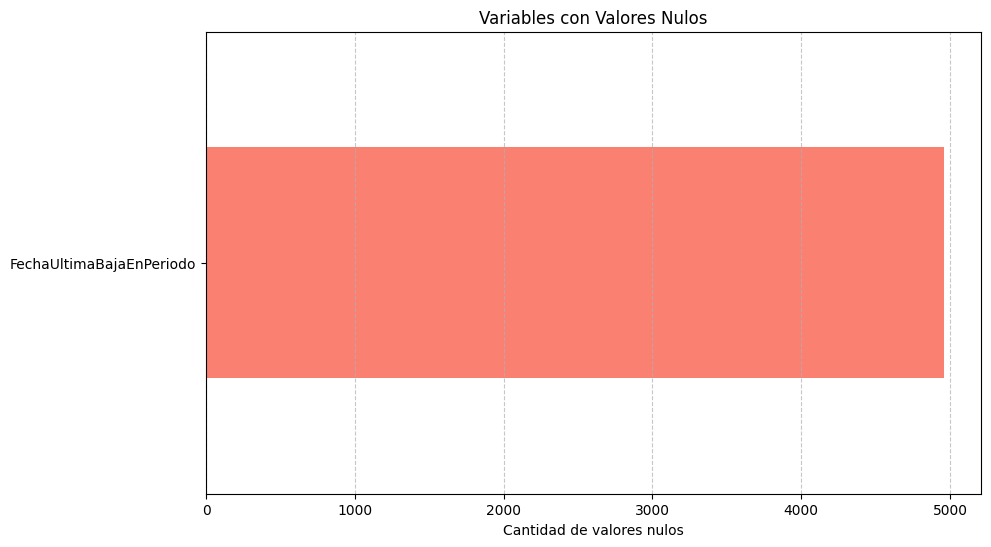


📎 Filas duplicadas:
✅ No hay filas duplicadas.

📎 Columnas duplicadas:
🔴 Hay 1 columnas duplicadas.


In [42]:
eda_basica(union_accesos_preparado, nombre_df="Dataframe final abonados")

No nos importa tratar ese nulo ya que no se utilizara a posterior en el modelo

In [43]:
# Check for duplicate columns
print("\n🔍 Duplicate Columns:")

# Transpose the abonado_altasFrame to check for duplicate columns
duplicated_columns = union_accesos_preparado.T.duplicated().sum()
if duplicated_columns > 0:
    display(union_accesos_preparado[union_accesos_preparado.duplicated()])  # Show duplicate columns
else:
    print('No duplicate columns')


🔍 Duplicate Columns:


,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,NumAltasEnPeriodo,MesesDesdePrimeraAltaEnPeriodo,EsChurn,FechaFin,VidaGymMeses,NumBajasEnPeriodo,FechaUltimaBajaEnPeriodo,MesesDesdeUltimaBaja,Importe_total_pagado_servicios,Cantidad_total_pagado_servicios,TipoServicio_ENTRENAMENTS PERSONALS,TipoServicio_FISIOTERÀPIA,TipoServicio_NUTRICIÓ,UsoServiciosExtra,ratio_importe_2025_2024,ratio_cantidad_2025_2024,Uso_entrenamientos_personales,Uso_fisioterapia,Uso_nutricion,Diversidad_servicios_extra,NumPagosEconomia,MediaIntervaloMeses,StdIntervaloMeses,UltimoPagoMesEconomia,PrimerPagoMesEconomia,MesesConPagoEconomia,PorcentajeMesesPagados,TotalPagadoEconomia,media_pagoEconomia,StdPagoEconomia,CoefVarPagoEconomia,PctPagoMetalico,PctPagoRecibo,PctPagoTarjeta,PctPagoTransferencia,NumAbonosDistintos,AbonoMasRecuente,TienePagos,TotalVisitas,DiasActivo,TiempoActivoDias,VisitasUlt30,VisitasUlt90,VisitasUlt180,PropUlt90,DiasDesdeUltima,tasa_caida_visitas,DuracionMediaTotal,DuracionMediaUlt90,DeltaDuracionUlt90VsTotal,StdDiasEntreVisitas,FrecuenciaModal,MaxRachaSinVisita,MaxRachaConVisita,SemanasConVisitaRatio,HoraMediaAcceso,PropVisitasFinDeSemana,PropVisitasFestivo,VisitasPrimerTrimestre,VisitasUltimoTrimestre,DiaFav_domingo,DiaFav_jueves,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos


Volvemos a intentar confirmar la columna duplicada que sale porque no he visto a nivel manual ninguna columna duplicada. Asi que lo ignoramos

| **Variable**                | **Descripción**                                                | **Utilidad para el modelo (predictiva y explicativa)**                          |
| --------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| `TotalVisitas`              | Número total de accesos o visitas al gimnasio                  | Mide nivel general de uso y compromiso con el centro                            |
| `DiasActivo`                | Número de días distintos en que ha accedido                    | Indica consistencia en el uso a lo largo del tiempo                             |
| `TiempoActivoDias`          | Días entre la primera y última visita registrada               | Muestra duración del vínculo o antigüedad del usuario                           |
| `VisitasUlt30`              | Número de accesos en los últimos 30 días                       | Captura la actividad más reciente y nivel de engagement actual                  |
| `VisitasUlt90`              | Número de accesos en los últimos 90 días                       | Refleja comportamiento reciente más estable                                     |
| `VisitasUlt180`             | Número de accesos en los últimos 180 días                      | Ayuda a entender el uso en un horizonte más amplio                              |
| `PropUlt90`                 | Proporción de visitas en los últimos 90 días respecto al total | Indica tendencia de actividad reciente comparada con la histórica               |
| `DiasDesdeUltima`           | Días desde la última visita hasta hoy                          | Puede indicar riesgo de abandono o inactividad                                  |
| `tasa_caida_visitas`        | Ratio visitas últimos 90 días vs primeras 90 días              | Mide crecimiento o caída del uso, importante para detectar abandono             |
| `DuracionMediaTotal`        | Duración media (minutos) por visita total                      | Perfil de tiempo que el usuario permanece en el gimnasio                        |
| `DuracionMediaUlt90`        | Duración media en últimos 90 días                              | Permite detectar cambios recientes en la duración de las visitas                |
| `DeltaDuracionUlt90VsTotal` | Cambio relativo en duración media últimos 90 días vs total     | Mide evolución en intensidad del uso                                            |
| `StdDiasEntreVisitas`       | Desviación estándar de días entre visitas                      | Refleja regularidad o irregularidad en el acceso                                |
| `FrecuenciaModal`           | Valor más frecuente de días entre visitas                      | Identifica patrón típico de frecuencia de visitas                               |
| `MaxRachaSinVisita`         | Máximo número de días consecutivos sin visita                  | Indica periodos largos de inactividad, posible señal de abandono                |
| `MaxRachaConVisita`         | Máximo número de días consecutivos con visitas                 | Mide continuidad o hábito de uso intenso                                        |
| `SemanasConVisitaRatio`     | Ratio de semanas con al menos una visita                       | Refleja constancia semanal del usuario                                          |
| `HoraMediaAcceso`           | Hora promedio de entrada al gimnasio (en formato decimal)      | Perfil de comportamiento horario, útil para segmentación                        |
| `DiaFavorito`               | Día de la semana con mayor número de accesos                   | Indica preferencias de días de visita                                           |
| `EstacionFavorita`          | Estación del año con más visitas                               | Refleja comportamiento estacional o hábitos según época                         |
| `PropVisitasFinDeSemana`    | Proporción de accesos en fines de semana                       | Ayuda a distinguir usuarios con hábitos distintos (fin de semana vs laborables) |
| `PropVisitasFestivo`        | Proporción de accesos en días festivos                         | Similar al anterior, indica nivel de uso en días especiales                     |
| `VisitasPrimerTrimestre`    | Número de visitas en el primer trimestre de registro           | Indica nivel inicial de uso                                                     |
| `VisitasUltimoTrimestre`    | Número de visitas en el último trimestre registrado            | Captura actividad reciente, ayuda a detectar cambios o abandono                 |


✅ ¿Qué aportan estas variables de accesos?

- Variables cuantitativas (número de visitas, duración media, ratios, tiempos entre visitas):

    · Proveen señales claras de intensidad y frecuencia de uso.

    · Reflejan la evolución del compromiso del usuario a lo largo del tiempo (ej. caída en visitas o rachas largas sin acceso pueden indicar riesgo de abandono).

    · Ayudan a detectar patrones regulares o irregulares en el comportamiento.

- Variables temporales y de tendencia (visitas en últimos 30, 90, 180 días, tasa de caída, días desde última visita):

    · Permiten capturar el comportamiento reciente y detectar cambios o tendencias.

    · Son fundamentales para anticipar abandono o reactivación.

- Variables relacionadas con duración y hábitos (duración media, cambios relativos, hora promedio de acceso):

    · Ayudan a entender la intensidad del uso y preferencias horarias del usuario.

    · Facilitan la segmentación según hábitos de uso (por ejemplo, usuarios que solo vienen por la mañana vs por la tarde).

- Variables de continuidad o rachas (máxima racha con o sin visita, semanas con visita ratio):

    · Miden la constancia y posibles pausas prolongadas.

    · Son muy útiles para identificar patrones estables vs inestables.

- Variables categóricas derivadas (día favorito, estación favorita, visitas en fin de semana o festivos):

    · Añaden contexto estacional y preferencias de uso.

    · Mejoran interpretabilidad y pueden ayudar a personalizar acciones o comunicaciones.

# GUARDAMOS DATAFRAME RESULTANTE 

In [45]:
# Guardar el DataFrame en un archivo CSV
union_accesos_preparado.to_csv('../data/dataframe_final_abonado.csv', index=False)